# Richardson-Lucy deconvolution: unfolding the spectrum

Model dependent. You've no idea how the specrtum looks like

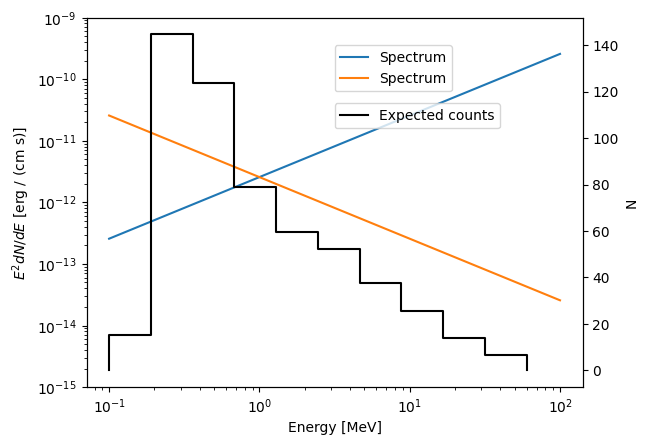

In [102]:
from gammaraytoys.detectors import PowerLawSpectrum, PointSource
from gammaraytoys.analysis import SpectralResponse
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from histpy import Histogram

duration = 1*u.day

index = -1 
flux_pivot = 1/u.erg/u.cm/u.s
pivot_energy = 1*u.MeV

source = PointSource(offaxis_angle = 0*u.deg,
                     spectrum = PowerLawSpectrum(index = index, 
                                                min_energy = 100*u.keV,
                                                max_energy = 100*u.MeV),
                     flux_pivot = flux_pivot,
                     pivot_energy = pivot_energy)

source2 = PointSource(offaxis_angle = 0*u.deg,
                     spectrum = PowerLawSpectrum(index = -3, 
                                                min_energy = 100*u.keV,
                                                max_energy = 100*u.MeV),
                     flux_pivot = flux_pivot,
                     pivot_energy = pivot_energy)

response = SpectralResponse.open("spectral_response_onaxis_traddet.h5")

expected_signal_counts = response.expected_counts(source, duration)
expected_signal_counts += response.expected_counts(source2, duration)

fig,axl = plt.subplots()

source.plot_spectrum(axl, e2 = True, label = 'Spectrum');
source2.plot_spectrum(axl, e2 = True, label = 'Spectrum');

axl.legend(loc = (.5,.8))

axr = axl.twinx()
expected_signal_counts.plot(axr, color = 'black', label = 'Expected counts')
axr.set_ylabel("N")
axr.legend(loc = (.5,.7))

(<Axes: xlabel='Ei [MeV]', ylabel='Em [MeV]'>,
 <matplotlib.collections.QuadMesh at 0x136f51d50>)

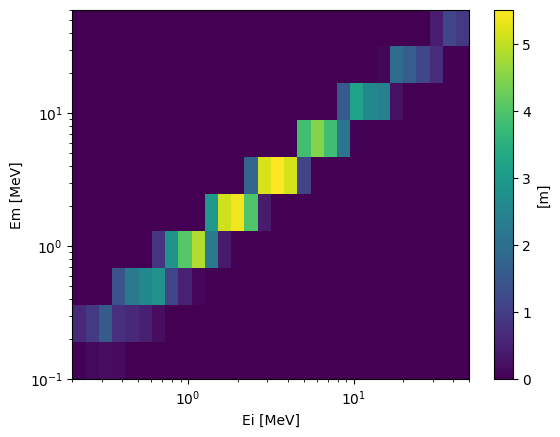

In [103]:
response.plot()

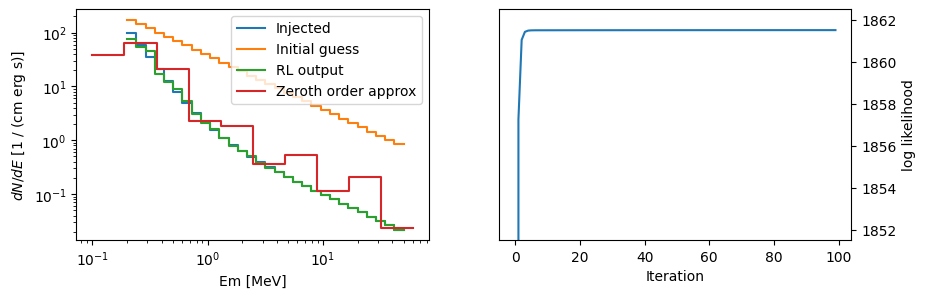

In [156]:
from copy import copy, deepcopy
from gammaraytoys.analysis import poisson_binned_log_likelihood

data = deepcopy(expected_signal_counts)

# See exercise below
#data[:] = np.random.poisson(data.contents)

approx_flux = Histogram(data.axis, data.contents)
approx_flux /= duration # Per time
approx_flux /= response.effective_area().interp(data.axis.centers) # Per area

model_0 = Histogram(response.axes['Ei'], unit = 1/u.cm/u.s)
model_0[:] = np.sum(data)/np.max(response.effective_area())/duration # Doesn't matter much
                    
# Bare contents
model = deepcopy(model_0)
R_ij = response.contents.transpose() * duration
R_j = response.effective_area().contents * duration
M_j = model.contents
N_i = data.contents

log_like = []

niter = 100
for t in range(niter):

    expectation = np.dot(R_ij, M_j)

    log_like.append(poisson_binned_log_likelihood(data, expectation))

    # nansum skips cases where both data and expectation are 0
    coeff = np.nansum((N_i/expectation)[:,None] * R_ij, axis = 0)
                      
    # Similar here. Handle R_j = 0
    norm_coeff = np.zeros_like(coeff)
    np.divide(coeff, R_j, out = norm_coeff,
              where = (coeff!=0) | (R_j != 0))
    
    M_j *= norm_coeff

model[:] = M_j


fig,axes = plt.subplots(figsize = [10,3], ncols = 2)
ax = axes[0]

#source.plot_spectrum(ax, e2 = True, label = 'Spectrum');
#source2.plot_spectrum(ax, e2 = True, label = 'Spectrum');

spec_binned = source.discretize_spectrum(response.axes['Ei'])
spec2_binned = source2.discretize_spectrum(response.axes['Ei'])

spect_tot_binned = spec_binned+spec2_binned

# To density and units
y_units = u.Unit(1/u.erg/u.cm/u.s)
spect_tot_binned_density = (spect_tot_binned/spect_tot_binned.axis.widths).to(y_units)
model_0_density = (model_0/model_0.axis.widths).to(y_units)
model_density = (model/model.axis.widths).to(y_units)
approx_flux_density = (approx_flux/approx_flux.axis.widths).to(y_units)

spect_tot_binned_density.plot(ax, label = "Injected")
model_0_density.plot(ax, label = "Initial guess")
model_density.plot(ax, label = "RL output")
approx_flux_density.plot(ax, label = "Zeroth order approx")

ax.set_yscale('log')

ax.set_ylabel(f'$dN/dE$ [{y_units}]')

#(approx_flux*approx_flux.axis.centers**2/approx_flux.axis.widths).to(u.erg/u.cm/u.s).plot(ax)
#(model_0*model_0.axis.centers**2/model_0.axis.widths).to(u.erg/u.cm/u.s).plot(ax, label = "Initial guess")
#(model*model.axis.centers**2/model.axis.widths).to(u.erg/u.cm/u.s).plot(ax, label = "RL output")

ax.legend()

ax = axes[1]
ax.plot(log_like)
ax.set_ylim(np.max(log_like) - 10, np.max(log_like)+1)
ax.set_ylabel('log likelihood')
ax.set_xlabel('Iteration')
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')

Converged quickly. Simple case
Observed break in the spectrum. Do not fit it directly (no errors). Do a forward folding instead. 

Ex: try different number of iteration
Excersize: Poisson data. Shot noise and artifacts, specially low exposure (small effective area). No errors.

## bkg and nuisance